
# Test clouds and skimage in a mountain range


### JAH, April 2021

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [2]:
import numpy             as np
import matplotlib.pyplot as plt

import clouds.clouds    as clouds
import clouds.pltclouds as pltclouds

import clouds.ridges    as ridges

In [3]:
import warnings
warnings.filterwarnings('ignore')

import time
print(' Last revision ', time.asctime())

 Last revision  Tue Apr 27 19:11:19 2021


## About the Ridge Detection

References:

* [Linderberg-98](http://kth.diva-portal.org/smash/record.jsf?pid=diva2%3A452310&dswid=812) and [Linderberg-08](),

* [Crowley-84](http://crowley-coutaz.fr//jlc/papers/Crowley-Parker84.pdf)

* [Sato-98](https://www.sciencedirect.com/science/article/pii/S1361841598800091) 3D Ridges


### Ridges In 2D

My definition:
A "Ridge" correspond to a line where locally the gradient coindides with one of the eigen-vectors of the hessianand the curvature in the ortogonal directions (u) to the gradient are negative (convex) and greather than the curvature in the gradient direction (v). 

in 2D:

$$
f_\phi = \cos \phi f_x + \sin \phi f_y \\
f_{\phi\phi} = \cos^2\phi f_{xx} + 2 \cos \phi \sin \phi f_{xy} + \sin^2 \phi f_{yy}
$$

The differential invariants:

$$
i) \; |\nabla f|^2 = f^2_x + f^2_y, \\
ii) \; \nabla^2 f = f_{xx} + f_{yy}, \\
ii) \mathrm{det}|H| = f_{xx} f_{yy} - 2 f_{xy}, \\
ii) \kappa(f) = f^2_x f_{yy} + f^2_x f_{xx} - 2 f_x f_y f_{xy}
$$

In the hessian eigen-vector (p, q) with p is the main eigen-direction of the hessian.

$$
f_p = 0, \; f_{pp} \le 0, \; |f_{pp}| \ge |f_{qq}|
$$

In the gradien basis (u, v), where v is the gradiant direction

$$
f_{uv} = 0, \; f_{uu} \le 0, |f_{uu}| \ge |f_{vv}|
$$

(*I understand this condition as the gradient direction as a minor eigen-direction of the hessian*)

### In the gradient basis

$$
{\bf e}_u = (\sin \phi, - \cos \phi), \; {\bf e}_v = (\cos \phi, \sin \phi), \; u \times v = k
$$

It translates to:

$$
f_{uu} = \sin^2 \phi f_{xx} - 2 \sin\phi \cos\phi f_{xy} + \cos^2 \phi f_{yy} \\
f_{vv} = \cos^2 \phi f_{xx} + 2 \sin\phi \cos\phi f_{xy} + \sin^2 \phi f_{yy} \\
f_{uv} = \cos\phi \sin\phi \, (f_{xx} - f_{yy}) - f_{xy} (\cos^2\phi - \sin^2 \phi) 
$$

The condition $f_{uv} = 0$ translates to:

$$
\tan 2 \phi = 2 \frac{f_{xx} - f_{yy}}{f_{xy}}
$$

### In the curvature basis

Definition of a ridge in terms of local differential geometry properties: a connect set of points where the intensity assumes a local maximum in the direction of the main curvature.

The conditions:

$$
f_p = 0, f_{pp} \lt 0, |f_{pp}| \gt  |f_{qq}|
$$

In this case, the rotation angle is giben by:

$$
\cos \beta = \sqrt{\frac{1}{2}\left( 1 + \frac{f_{xx} - f_{yy}}{\sqrt{(f_{xx} - f_{yy})^2 + 4 f_{xy}}} \right)}  \\
\sin \beta = \frac{f_{xy}}{|f_{xy}|}\sqrt{\frac{1}{2}\left( 1 - \frac{f_{xx} - f_{yy}}{\sqrt{(f_{xx} - f_{yy})^2 + 4 f_{xy}}} \right)}  \\
$$

The basis vector are:

$$
{\bf e}_p = (\sin \beta, -\cos \beta), \; {\bf e}_q = (\cos \beta, \sin \beta)
$$

## Generate sample

In [4]:
def generate_points(sizes, line = None, sigma = 1):
    
    npoints = len(sizes)
    ts = np.linspace(0, 1., npoints)
    ts = [ni * [ti,] for ni, ti in zip(sizes, ts)]
    ts = np.concatenate(ts)

    size = len(ts)
    iden = lambda x: x
    x, y = (iden, iden) if line is None else line
    xs   = x(ts) + sigma * np.random.normal(size = size)
    ys   = y(ts) + sigma * np.random.normal(size = size)
    
    return xs, ys

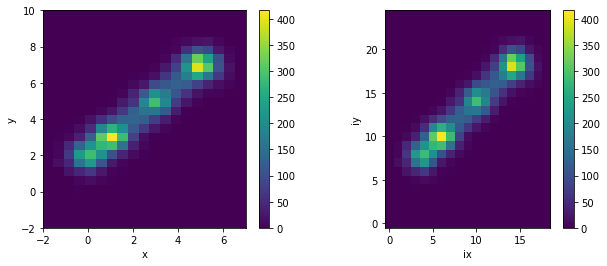

In [5]:
sizes = 1000 * np.array((2, 3, 1, 2, 1, 3))
scale, offset = 5, 2
line  = lambda x: scale * x,  lambda x: offset + scale * x
xs, ys = generate_points(sizes, line, sigma = 0.5)

size  = 2 
xbins = np.linspace(-2,  7, size * 10)
ybins = np.linspace(-2, 10, size * 13)

bins  = (xbins, ybins)
counts, _, _  = np.histogram2d(xs, ys, bins = bins)

plt.figure(figsize = (5 * 2, 1 * 4))
plt.subplot(1, 2, 1)
plt.hist2d(xs, ys, bins);
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar();
plt.subplot(1, 2, 2)
plt.imshow(counts.T, origin = 'lower')
plt.xlabel('ix'); plt.ylabel('iy')
plt.colorbar();


In [6]:
#print(plt.rcParams.keys());

### Create clouds potential

steps  (0.4736842105263157, 0.48)


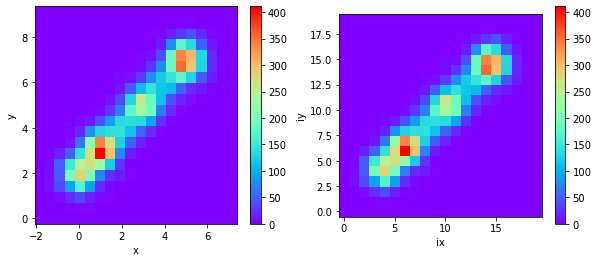

In [7]:
plt.rcParams['image.cmap'] = 'rainbow'
coors = (xs, ys)
ones  = np.ones(len(xs))
steps = (xbins[1]-xbins[0], ybins[1] - ybins[0])
print('steps ', steps)
bins, icells, cells, enes, kids = clouds.clouds_potential(coors, steps, ones)

counts, _, _ = np.histogram2d(*cells, bins = bins, weights = enes)

plt.figure(figsize = (2 * 5, 1 * 4))
plt.subplot(1, 2, 1)
plt.hist2d(*cells, bins = bins, weights = enes);
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar();
plt.subplot(1, 2, 2)
plt.imshow(counts.T, origin = 'lower')
plt.xlabel('ix'); plt.ylabel('iy')
plt.colorbar();

#### Clouds gradient

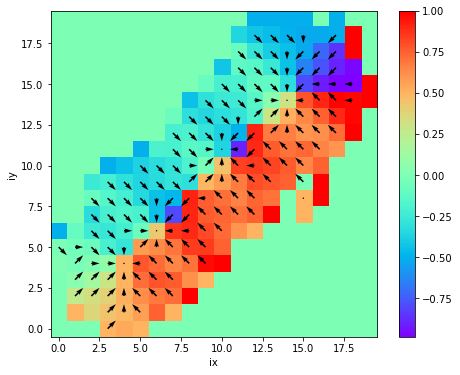

In [8]:
egrad, epath = clouds.clouds_gradient(bins, cells, enes, kids) 
plt.figure(figsize = (8, 6))
pltclouds.dcloud_grad(icells, epath)
plt.xlabel('x'); plt.ylabel('y')
lx, ly = np.gradient(counts)
phi = np.arctan2(ly, lx)/np.pi
plt.imshow(phi.T, origin = 'lower');
plt.xlabel('ix'); plt.ylabel('iy');
plt.colorbar();

In [9]:
ngrad = clouds.clouds_neighbours_grad(bins, cells, kids, epath) 

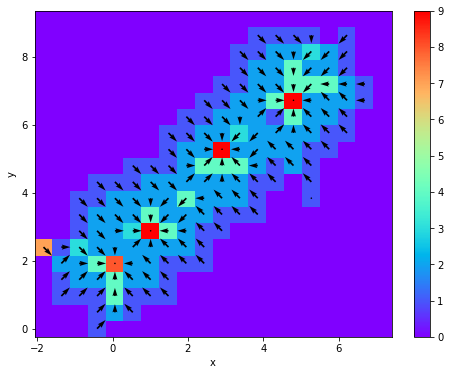

In [10]:
plt.figure(figsize = (1 * 8, 1 * 6))
plt.hist2d(*cells, bins = bins, weights = ngrad);
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar();
pltclouds.dcloud_grad(cells, epath)

In [11]:
hess          = ridges.hessian(counts)
i0, i1, theta = ridges.hess2d_eigvals(hess)
imin = np.minimum(i0, i1)

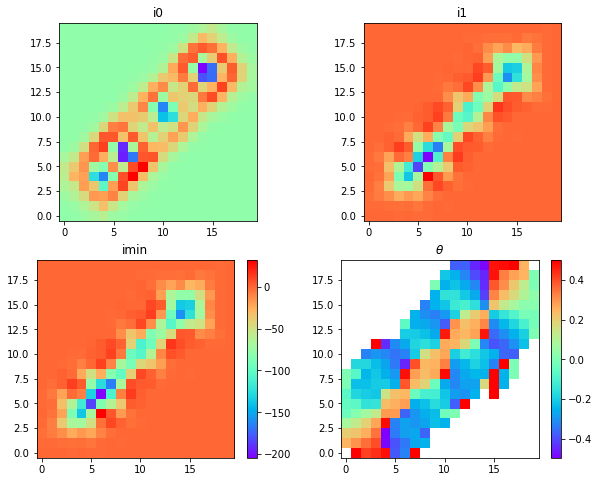

In [12]:
plt.figure(figsize = (2 * 5, 2 * 4))

plt.subplot(2, 2, 1)
plt.imshow(i0.T, origin = 'lower');
plt.title('i0')
plt.subplot(2, 2, 2)
plt.imshow(i1.T, origin = 'lower');
plt.title('i1')
plt.subplot(2, 2, 3)
plt.imshow(imin.T, origin = 'lower');
plt.colorbar();
plt.title('imin')
plt.subplot(2, 2, 4)
plt.imshow(theta.T, origin = 'lower');
plt.title(r'$\theta$')
plt.colorbar();

### Identify the edges

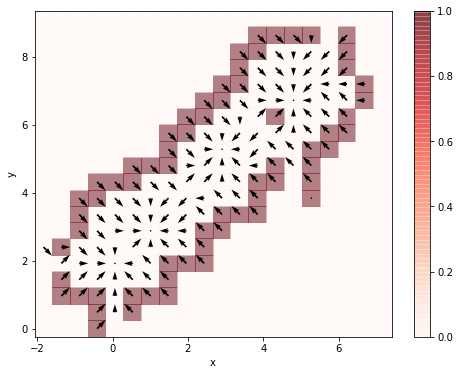

In [13]:
csel_ = pltclouds._csel
isel = ngrad == 1
plt.figure(figsize = (1 * 8, 1 * 6))
plt.hist2d(*csel_(cells, isel), bins = bins, weights = ngrad[isel], cmap = 'Reds', alpha = 0.5);
plt.xlabel('x'); plt.ylabel('y')
plt.colorbar();
pltclouds.dcloud_grad(cells, epath)

### Relation with the bordes

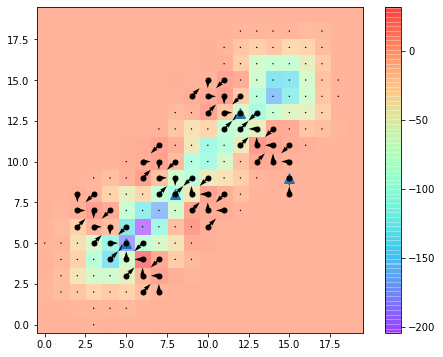

In [18]:
nodes, enodes, _    = clouds.clouds_nodes(enes, kids, epath)
lgrad, lnode, lpath = clouds.clouds_gradient_link(bins, cells, enes, nodes, kids)
epass  = clouds.clouds_passes(enes, nodes, enodes, lnode, kids, lgrad, lpath)
isel   = epass > 0

plt.figure(figsize = (8, 6))
pltclouds.dcloud_grad (icells, lpath)
plt.imshow(imin.T, origin = 'lower', alpha = 0.5);
plt.plot(*csel_(icells, isel), marker = '^', ls = '', ms = 10)
isel = (lnode > 0) & (nodes != lnode)
plt.plot(*csel_(icells, isel), marker = 'o', color ='black', ls = '', ms = 5)

plt.colorbar();

In [15]:
isel = epass > 0
print(imin[csel_(icells, isel)])
isel = (lnode > 0) & (nodes != lnode)
print(sorted(imin[csel_(icells, isel)]))
print(sorted(enes[isel], reverse = True))


[-1.83816372e+02 -9.90482526e+01 -6.44698625e+01  3.64745084e-02]
[-183.8163717626105, -136.37524801489664, -131.9354829987038, -115.11218883670355, -103.9230425401996, -99.0482526170124, -88.12609862338302, -84.9284363330921, -84.49436449377926, -83.07391984473668, -73.29751401331961, -67.6353747855417, -67.4156239848769, -64.46986247928047, -63.96022498867101, -48.4070209965578, -46.332418576610294, -44.00995857891165, -41.372782194597924, -40.053600492916146, -20.70946008987154, -16.881814063159418, -12.405538464297763, -9.027588683792064, -8.891281452468014, -6.905648330464295, -5.0754766241778455, -2.857881008493905, -1.7987067523716007, -0.8738718227756834, -0.5712578928640202, -0.5, 0.03647450843757882, 0.47553713191489777, 0.5, 1.6215304528350067, 1.6491951840589287, 1.726339361087737, 3.0354041800389595, 3.0733652044351514, 3.651813102570264, 3.956295842289123, 4.008852331460966, 4.196510318458042, 4.42789683955457, 4.840825483717921, 5.011036576825177, 5.919960291215276, 6.06

**Note**:

   * The pass is NOT the point with the largest negative curvature, but veru close.
   
   * Accept only passes with negative large curvature. 

### Clouds

In [16]:
df = clouds.clouds(coors, steps, ones)

{'cells': True, 'gradients': False, 'nodes': True, 'links': False, 'passes': False, 'segments': False, 'tracks': False, 'crests': True}


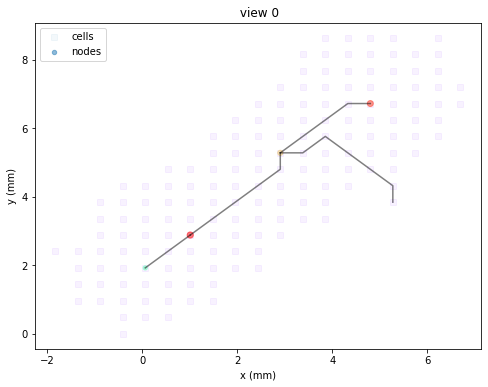

In [17]:
draw, plots = pltclouds.get_draw_clouds(df)
print(plots)
draw(plots, scale = 0.01)